# Prep the DMS + Octet data for tdms training

In [1]:
# Imports
import pickle
import json
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import torch
from Bio.Seq import Seq
from Bio import SeqIO
import binarymap
%matplotlib inline

## 1: Merge and clean raw data

In [2]:
# directory where all all input and output is organized
data_dir = "../nextflow/data/torchdms/raw-dms"
prepped_dir = "../nextflow/data/torchdms/prepped-dms"

# other relative paths
wt_seq_path = f"{data_dir}/wildtype_sequence.fasta"
raw_bind = f"{data_dir}/bc_binding.csv"
raw_expr = f"{data_dir}/bc_expression.csv"
raw_poly = f"{data_dir}/bc_polyspecificity.csv"

In [3]:
raw_cols = ['log10Ka', 'expression', 'polyspecificity_02']
raw_dfs = [pd.read_csv(raw_bind), pd.read_csv(raw_expr), pd.read_csv(raw_poly)]
new_cols = ["bind", "stab", "poly"]

In [4]:
# Sequence information from Tyler's repo
record = SeqIO.read(wt_seq_path, 'fasta')
dna_seq = record.seq     
wtseq = dna_seq.translate()
len(wtseq)

235

**now let's merge the scores into a single df**

In [5]:
full_df = reduce(
        lambda l, r: pd.merge(l, r, how='inner',
            on=['library','target', 'barcode', 'variant_class', 'aa_substitutions','n_aa_substitutions'],
            sort=False
        ),
        raw_dfs,
    ).rename(dict(zip(raw_cols, new_cols)), axis=1)

full_df.aa_substitutions = full_df.aa_substitutions.fillna(' ')
full_df.n_aa_substitutions = [len(s.split()) for s in full_df.aa_substitutions.values]

In [6]:
full_df[new_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192429 entries, 0 to 192428
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bind    140191 non-null  float64
 1   stab    175070 non-null  float64
 2   poly    150390 non-null  float64
dtypes: float64(3)
memory usage: 5.9 MB


**We only drop examples where non of the targets have valid measurements (i.e. notnull)**

In [7]:
to_drop_query = " | ".join([f"{target}.notnull()" for target in new_cols])

full_df = full_df.query(to_drop_query)

In [8]:
full_df[new_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177939 entries, 0 to 192428
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bind    140191 non-null  float64
 1   stab    175070 non-null  float64
 2   poly    150390 non-null  float64
dtypes: float64(3)
memory usage: 5.4 MB


In [9]:
full_df.variant_class.value_counts()

1 nonsynonymous     141592
wildtype             21560
>1 nonsynonymous     13493
stop                   682
synonymous             612
Name: variant_class, dtype: int64

In [10]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177939 entries, 0 to 192428
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   library             177939 non-null  object 
 1   barcode             177939 non-null  object 
 2   target              177939 non-null  object 
 3   variant_class       177939 non-null  object 
 4   aa_substitutions    177939 non-null  object 
 5   n_aa_substitutions  177939 non-null  int64  
 6   TiteSeq_avgcount    177939 non-null  float64
 7   bind                140191 non-null  float64
 8   expr_count          175089 non-null  float64
 9   stab                175070 non-null  float64
 10  psr_count_01        153047 non-null  float64
 11  polyspecificity_01  148596 non-null  float64
 12  psr_count_02        153961 non-null  float64
 13  poly                150390 non-null  float64
 14  psr_count_03        148500 non-null  float64
 15  polyspecificity_03  144618 non-nul

## 2: WT summary stats

now, we'll take a look at the wildtype dummary stats to get an idea of the variance among many replicates, and to get an idea of difference when compared to mutants of various strata (N-mutations). This is because we want to predict delta's (change in affinity) of mutants when compared to the wildtype. We also want to know about any batch-specific differences between the two libraries being used

In [11]:
# non-synonymous mutants count as wildtype.
wt_df = full_df.query("n_aa_substitutions == 0")

In [12]:
wt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22172 entries, 10 to 192426
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   library             22172 non-null  object 
 1   barcode             22172 non-null  object 
 2   target              22172 non-null  object 
 3   variant_class       22172 non-null  object 
 4   aa_substitutions    22172 non-null  object 
 5   n_aa_substitutions  22172 non-null  int64  
 6   TiteSeq_avgcount    22172 non-null  float64
 7   bind                18027 non-null  float64
 8   expr_count          21769 non-null  float64
 9   stab                21768 non-null  float64
 10  psr_count_01        19662 non-null  float64
 11  polyspecificity_01  19237 non-null  float64
 12  psr_count_02        19810 non-null  float64
 13  poly                19450 non-null  float64
 14  psr_count_03        19122 non-null  float64
 15  polyspecificity_03  18625 non-null  float64
 16  ps

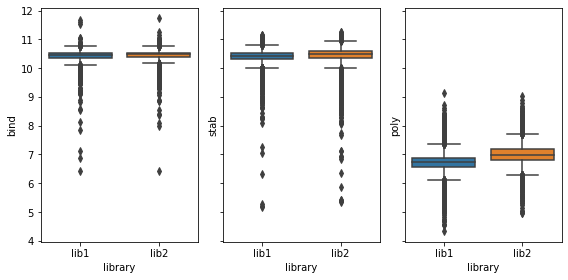

In [13]:
fig, ax = plt.subplots(1,3, figsize=[8,4],sharex=True, sharey=True)
for col, metric in enumerate(new_cols):
    sns.boxplot(x="library", y=metric, data=wt_df, ax=ax[col])
plt.tight_layout()
plt.show()

## 3: Mutant summary stats

In [14]:
# calculate deltas from wt
mutants = full_df.query("n_aa_substitutions != 0").copy()

In [15]:
mutants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155767 entries, 0 to 192428
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   library             155767 non-null  object 
 1   barcode             155767 non-null  object 
 2   target              155767 non-null  object 
 3   variant_class       155767 non-null  object 
 4   aa_substitutions    155767 non-null  object 
 5   n_aa_substitutions  155767 non-null  int64  
 6   TiteSeq_avgcount    155767 non-null  float64
 7   bind                122164 non-null  float64
 8   expr_count          153320 non-null  float64
 9   stab                153302 non-null  float64
 10  psr_count_01        133385 non-null  float64
 11  polyspecificity_01  129359 non-null  float64
 12  psr_count_02        134151 non-null  float64
 13  poly                130940 non-null  float64
 14  psr_count_03        129378 non-null  float64
 15  polyspecificity_03  125993 non-nul

## 4: Calculate delta's from wildtype average.

$\Delta$ $M_{Pi}$ = $M_{Pi}$ - ($1/N$ $\sum_{n=0}^{N}{WT}_{Pn}$)

In [16]:
for lib, lib_df in wt_df.groupby("library"):
    print(lib)
    for metric in new_cols:
        mean_lib_metric = round(np.mean(lib_df[metric]), 5)
        print(f"  mean {metric}: {mean_lib_metric}")
        mutants[f"delta_{metric}"] = mutants[metric] - mean_lib_metric

lib1
  mean bind: 10.41134
  mean stab: 10.39789
  mean poly: 6.72648
lib2
  mean bind: 10.44189
  mean stab: 10.44624
  mean poly: 7.01713


## 5: Bacode replicate summary stats 

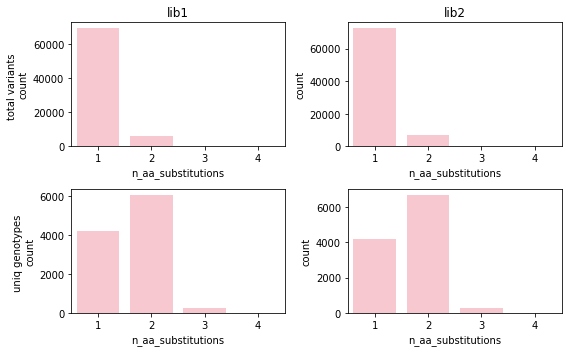

In [17]:
# How many unique variants are in the library by codon-substution number?
fig, ax = plt.subplots(2,2, figsize=[8, 5])
for i,(lib, lib_df) in enumerate(mutants.groupby('library')):
    uniq_geno_lib_df = lib_df.groupby("aa_substitutions").first()
    sns.countplot(data=uniq_geno_lib_df, x='n_aa_substitutions', color="pink", ax=ax[1, i])
    sns.countplot(data=lib_df, x="n_aa_substitutions", color="pink", ax=ax[0, i])
    ax[0, i].set_title(lib)

ax[0, 0].set_ylabel("total variants \ncount")
ax[1, 0].set_ylabel("uniq genotypes \ncount")
plt.tight_layout()
plt.show()

## 6: Aggragate barcodes for mutants

In [18]:
mean_collapsed_mutants = mutants.groupby(['library', 'variant_class', 'aa_substitutions']).mean().reset_index()

17,615 total examples in mean collapsed where delta bind, stab, and poly are non null.

In [19]:
datas = {
    "Mutants\n(separate)" :  mutants,
    "Mutants\n(Collapsed By Barcode)": mean_collapsed_mutants,
}

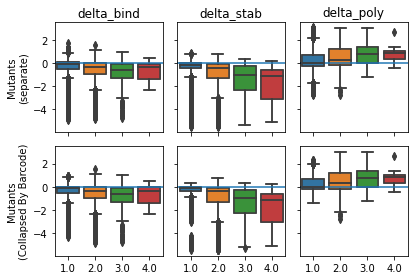

In [20]:
new_cols_delta = [f"delta_{c}" for c in new_cols]

fig, ax = plt.subplots(len(datas),3, figsize=[6, 4], sharex=True, sharey=True)
for col, metric in enumerate(new_cols_delta):
    for row, (key, value) in enumerate(datas.items()):
        cur_ax = ax[row, col] if len(datas) > 1 else ax[col]
        sns.boxplot(x="n_aa_substitutions", y=metric, data=value, ax=cur_ax)
        sns.boxplot(x="n_aa_substitutions", y=metric, data=value, ax=cur_ax)
        cur_ax.set_ylabel("")
        cur_ax.set_xlabel("")
        if row == 0: cur_ax.set_title(metric)
        if col == 0: cur_ax.set_ylabel(key)
        cur_ax.axhline()

fig.xlabel = "N AA Subs"
plt.tight_layout()

plt.show()

# 8: octet data

**load the octet data and convert the mutations to tdms format**

In [21]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
octet_df = pd.read_csv(f"{data_dir}/octet_data.csv")

In [22]:
octet_df

,ID,HCmut,LCmut,aa_mut_total,deltaKd_additive_foldchange,deltaKd_additive,octet_Kd_foldchange_avg,kd,kon,kdis,R^2
0,#26 Fab4,"K49R, Y58F",A40G,3,7.462082,0.87286,6.364276,2.840000e-09,126300,0.000359,0.9993
1,A40G,GL,A40G,1,7.172326,0.85566,6.952912,4.210000e-09,90900,0.000383,0.9997
2,A40V,GL,A40V,1,0.193201,-0.71399,0.642593,5.400000e-08,142000,0.007670,0.9746
3,"A40V, N108D",GL,"A40V, N108D",2,0.031422,-1.50277,0.376934,7.110000e-08,111000,0.007920,0.9266
4,D28A,D28A,GL,1,6.835810,0.83479,5.774278,3.810000e-09,225000,0.000858,0.9944
5,EH1,"D28A, K44R, S64G","A40G, Y42F, A52S, Q105H, N108Y",8,2558.998315,3.40807,308.192458,7.690000e-11,933000,0.000072,0.9919
6,EH2,"D28A, K49R, S64G","A40G, Y42F, A52S, Q105H, N108Y",8,2154.269337,3.33330,383.495146,6.180000e-11,1030000,0.000063,0.9947
7,EH3,"D28A, K44R, K49R, S64G","A40G, Y42F, A52S, Q105H, N108Y",9,2499.769702,3.39790,361.280488,6.560000e-11,1050000,0.000069,0.9900
8,GL,GL,GL,0,1.000000,0.00000,1.000000,2.600000e-08,86700,0.002260,0.9900
9,K44R,K44R,GL,1,1.160379,0.06460,0.986547,2.230000e-08,152000,0.003400,0.9950


In [23]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,mutant,codon,single_nt,bind,delta_bind,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,A,GAG,True,10.48829,0.03110,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,C,GAG,False,10.44477,-0.01243,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,D,GAG,True,10.42771,-0.02948,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,E,GAG,True,10.45719,0.00000,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,F,GAG,False,10.51899,0.06180,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R124(L)S,CGG_naive,R,235,124,L,S,CGT,True,10.44756,-0.00963,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-124
R124(L)T,CGG_naive,R,235,124,L,T,CGT,False,10.43023,-0.02696,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-124
R124(L)V,CGG_naive,R,235,124,L,V,CGT,False,10.38231,-0.07488,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-124


In [24]:
for row_idx, row in octet_df.iterrows():
    igh_mutations = [f"{(y := x.rstrip(','))[:-1]}(H){y[-1]}".rstrip(",") for x in row.HCmut.split() if "GL" not in x]
    igk_mutations = [f"{(y := x.rstrip(','))[:-1]}(L){y[-1]}".rstrip(",") for x in row.LCmut.split() if "GL" not in x]
    
    all_mutations = igh_mutations + igk_mutations
    
    if any("*" in x for x in all_mutations):
        delta_bind = None
    else:
        delta_bind = dms_df.delta_bind[all_mutations].sum()
    octet_df.loc[row_idx, "delta_bind_additive"] = delta_bind
    
    converted_mutations = []
    
    aa_seq = pos_df.amino_acid.copy()
    for mutation in all_mutations:
        chain = mutation[-3]
        pos = int(mutation[1:-4])
        wildtype = mutation[0]
        mutant = mutation[-1]
        idx = pos_df.index[(pos_df.site == pos) & (pos_df.chain == chain)]
        assert len(idx) == 1
        idx = idx[0]
        assert aa_seq[idx] == wildtype
        converted_mutations.append("".join([wildtype, str(idx), mutant]))
    octet_df.loc[row_idx, "aa_substitutions"] = " ".join(converted_mutations) 
    
octet_df["delta_bind"] = np.log10(octet_df.octet_Kd_foldchange_avg)
octet_df["library"] = "octet"

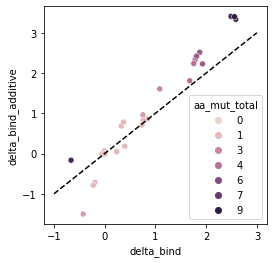

In [25]:
fig, ax = plt.subplots(1, figsize=[4, 4])
sns.scatterplot(data=octet_df, y="delta_bind_additive", x="delta_bind", hue="aa_mut_total", ax = ax)
ax.plot((-1, 3), (-1, 3), 'k--')

In [26]:
octet_df.aa_mut_total.value_counts().sort_index()

0     1
1    13
2     2
3     2
4     3
5     3
8     3
9     1
Name: aa_mut_total, dtype: int64

**merge it with the training data**

In [27]:
octet_df_tdms = octet_df[["library", "delta_bind","aa_substitutions", "aa_mut_total"]].rename({"aa_mut_total":"n_aa_substitutions"}, axis=1)
octet_df_tdms

,library,delta_bind,aa_substitutions,n_aa_substitutions
0,octet,0.803749,K44R Y53F A161G,3
1,octet,0.842167,A161G,1
2,octet,-0.192064,A161V,1
3,octet,-0.423735,A161V N219D,2
4,octet,0.761498,D27A,1
5,octet,2.488822,D27A K39R S56G A161G Y163F A173S Q216H N219Y,8
6,octet,2.583760,D27A K44R S56G A161G Y163F A173S Q216H N219Y,8
7,octet,2.557845,D27A K39R K44R S56G A161G Y163F A173S Q216H N219Y,9
8,octet,0.000000,,0
9,octet,-0.005882,K39R,1


In [28]:
tdms_data_dms = mean_collapsed_mutants[["library", "delta_bind", "delta_stab", "aa_substitutions", "n_aa_substitutions"]]
tdms_data_dms_octet = pd.concat([tdms_data_dms, octet_df_tdms], ignore_index=True)
tdms_data_dms_octet

,library,delta_bind,delta_stab,aa_substitutions,n_aa_substitutions
0,lib1,0.005933,-0.079227,A104C,1.0
1,lib1,-0.164475,-0.156628,A104D,1.0
2,lib1,-0.116686,-0.051431,A104E,1.0
3,lib1,-0.105107,-0.057073,A104F,1.0
4,lib1,-0.079809,-0.006804,A104G,1.0
...,...,...,...,...,...
21790,octet,0.370343,NaN,N219Y,1.0
21791,octet,0.753072,NaN,Q216H N219Y,2.0
21792,octet,-0.226826,NaN,N219D,1.0
21793,octet,1.927590,NaN,K44R A161G Y163F A173S N219S,5.0


(-5.0, 5.0)

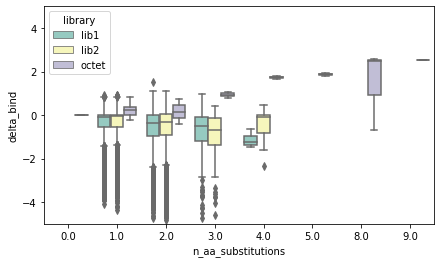

In [29]:
fig, ax = plt.subplots(figsize=[7, 4])
sns.boxplot(
    x="n_aa_substitutions", 
    y="delta_bind", 
    hue="library",
    data=tdms_data_dms_octet, 
    palette="Set3", 
    ax = ax
)
ax.set_ylim(-5,5)

**Write to disk**

In [30]:
# write data w/ octet
with open(f"{prepped_dir}/dms-octet.pkl", "wb") as f:
    pickle.dump([tdms_data_dms_octet, str(wtseq)], f)
    print(f"wrote {f}")

wrote <_io.BufferedWriter name='../nextflow/data/torchdms/prepped-dms/dms-octet.pkl'>


In [31]:
tdms_data_dms_octet.n_aa_substitutions.value_counts()

2.0    12768
1.0     8444
3.0      553
4.0       22
8.0        3
5.0        3
9.0        1
0.0        1
Name: n_aa_substitutions, dtype: int64

# 9: `torchdms` prep

**prep the data for tdms training**

In [32]:
! mkdir -p {prepped_dir}/dms-baseline-drop-na

In [33]:
# prep baseline 
! tdms prep \
    --seed 23 \
    --per-stratum-variants-for-test 150 \
    --skip-stratum-if-count-is-smaller-than 500 \
    --train-on-all-single-mutants \
    --drop-nans \
    {prepped_dir}/dms-octet.pkl \
    {prepped_dir}/dms-baseline-drop-na/data.prepped \
    delta_bind delta_stab

LOG: Setting random seed to 23.
LOG: Targets: ('delta_bind', 'delta_stab')
LOG: dropping NaNs as requested.
LOG: There are 18257 total variants in this dataset
LOG: placing all single mutants in training dataset as requested.
LOG: There are 8352 training samples for stratum: 1
LOG: There are 9226 training samples for stratum: 2
LOG: There are 150 validation samples
LOG: There are 151 test samples
LOG: Successfully partitioned data
LOG: preparing binary map dataset
LOG: Successfully finished prep and dumped SplitDataset object to ../nextflow/data/torchdms/prepped-dms/dms-baseline-drop-na/data.prepped


In [34]:
! mkdir -p {prepped_dir}/dms-baseline-keep-na

In [35]:
! tdms prep \
    --seed 23 \
    --per-stratum-variants-for-test 150 \
    --skip-stratum-if-count-is-smaller-than 500 \
    --train-on-all-single-mutants \
    {prepped_dir}/dms-octet.pkl \
    {prepped_dir}/dms-baseline-keep-na/data.prepped \
    delta_bind delta_stab

LOG: Setting random seed to 23.
LOG: Targets: ('delta_bind', 'delta_stab')
LOG: There are 21795 total variants in this dataset
LOG: placing all single mutants in training dataset as requested.
LOG: There are 8444 training samples for stratum: 1
LOG: There are 12466 training samples for stratum: 2
LOG: There are 252 training samples for stratum: 3
LOG: There are 303 validation samples
LOG: There are 300 test samples
LOG: Successfully partitioned data
LOG: preparing binary map dataset
LOG: Successfully finished prep and dumped SplitDataset object to ../nextflow/data/torchdms/prepped-dms/dms-baseline-keep-na/data.prepped


In [36]:
! mkdir -p {prepped_dir}/dms-strata-ceiling-3

In [41]:
! tdms prep \
    --seed 23 \
    --per-stratum-variants-for-test 50 \
    --skip-stratum-if-count-is-smaller-than 200 \
    --train-on-all-single-mutants \
    --strata-ceiling 3 \
    {prepped_dir}/dms-octet.pkl \
    {prepped_dir}/dms-strata-ceiling-3/data.prepped \
    delta_bind delta_stab

LOG: Setting random seed to 23.
LOG: Targets: ('delta_bind', 'delta_stab')
LOG: There are 21795 total variants in this dataset
LOG: placing all single mutants in training dataset as requested.
LOG: There are 8444 training samples for stratum: 1
LOG: There are 12668 training samples for stratum: 2
LOG: There are 481 training samples for stratum: 3
LOG: There are 101 validation samples
LOG: There are 100 test samples
LOG: Successfully partitioned data
LOG: preparing binary map dataset
LOG: Successfully finished prep and dumped SplitDataset object to ../nextflow/data/torchdms/prepped-dms/dms-strata-ceiling-3/data.prepped


In [42]:
! mkdir -p {prepped_dir}/dms-strata-ceiling-4

In [43]:
! tdms prep \
    --seed 23 \
    --per-stratum-variants-for-test 8 \
    --skip-stratum-if-count-is-smaller-than 24 \
    --train-on-all-single-mutants \
    --strata-ceiling 4 \
    {prepped_dir}/dms-octet.pkl \
    {prepped_dir}/dms-strata-ceiling-4/data.prepped \
    delta_bind delta_stab

LOG: Setting random seed to 23.
LOG: Targets: ('delta_bind', 'delta_stab')
LOG: There are 21795 total variants in this dataset
LOG: placing all single mutants in training dataset as requested.
LOG: There are 8444 training samples for stratum: 1
LOG: There are 12752 training samples for stratum: 2
LOG: There are 537 training samples for stratum: 3
LOG: There are 13 training samples for stratum: 4
LOG: There are 24 validation samples
LOG: There are 24 test samples
LOG: Successfully partitioned data
LOG: preparing binary map dataset
LOG: Successfully finished prep and dumped SplitDataset object to ../nextflow/data/torchdms/prepped-dms/dms-strata-ceiling-4/data.prepped


In [44]:
! tree {prepped_dir} -I "Attic"

../nextflow/data/torchdms/prepped-dms
├── dms-baseline-drop-na
│   ├── data.prepped.measurements.pdf
│   └── data.prepped.pkl
├── dms-baseline-keep-na
│   ├── data.prepped.measurements.pdf
│   └── data.prepped.pkl
├── dms-octet.pkl
├── dms-strata-ceiling-3
│   ├── data.prepped.measurements.pdf
│   └── data.prepped.pkl
└── dms-strata-ceiling-4
    ├── data.prepped.measurements.pdf
    └── data.prepped.pkl

4 directories, 9 files
